In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

from mrcnn.model import log

%matplotlib inline 

# Import Food256 
from food256 import Food256config
from food256 import Food256dataset 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [12]:

filename = 'data_coco.pkl'  # pkl dump in dataset root
train_data = Food256dataset()
#train_data.prepareCocoFormat(filename)
train_data.getSplit(filename)
train_data.load_food256(filename, 'train')
train_data.load_mask(134)
train_data.prepare()



 Reading bounding box info...

Done.

Reading image files...



100%|██████████| 21976/21976 [00:00<00:00, 82458.15it/s]


Done!



In [14]:
print(len(train_data.image_info))

21976


[118]


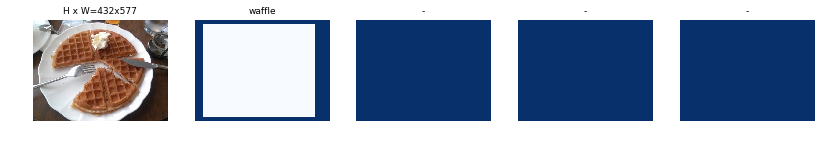

[123]


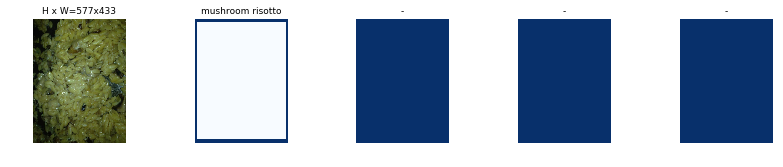

[85]


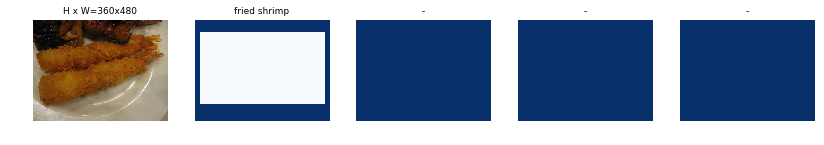

[74]


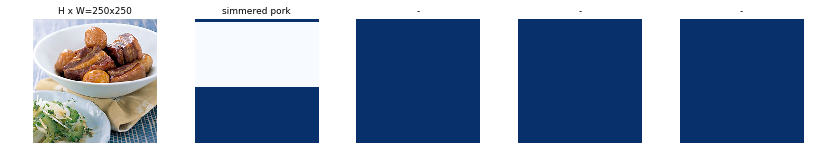

In [15]:
# Load and display random samples
image_idx = np.random.choice(train_data.image_ids, 4)

for image_id in image_idx:
    image = train_data.load_image(image_id)
    mask, class_ids = train_data.load_mask(image_id)
    print class_ids
    visualize.display_top_masks(image, mask, class_ids, train_data.class_names)

In [16]:
# Config
config = Food256config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                269
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INST

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_data, train_data,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/morpheus/work/food_proj/Mask_RCNN/logs/food25620180728T1341/mask_rcnn_food256_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
('In model: ', 'rpn_model')
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)


/home/morpheus/programs/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/morpheus/programs/anaconda2/lib/python2.7/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/morpheus/programs/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/morpheus/programs/anaconda2/lib/python2.7/site-packages/skimage/transf

Epoch 1/1


/home/morpheus/programs/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/morpheus/programs/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
ERROR:root:Error processing image {'source': 'food256', 'bb': [{'y': [49, 49, 289, 289], 'x': [7, 296, 296, 7]}, {'y': [49, 49, 289, 289], 'x': [7, 296, 296, 7]}], 'width': 300, 'path': 'data/UECFOOD256/92/12454.jpg', 'category_id': 92, 'id': 25784, 'height': 300}
Traceback (most recent call last):
  File "/home/morpheus/work/food_proj/Mask_RCNN/mrcnn/model.py", line 1817, in data_generator
    use_mini_mask=config.U

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
weight_file="food256_t1"
model_path = os.path.join(MODEL_DIR, weight_file+".h5")
model.keras_model.save_weights(model_path)

In [ ]:
# Dectection

In [ ]:
class InferenceConfig(Food256config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, weight_file+".h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)